<a href="https://colab.research.google.com/github/yihaozhong/Mining-Massive-Data-Sets/blob/main/CS246_Colab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS246 - Colab 2
## Frequent Pattern Mining in Spark

In [1]:
from IPython.display import Image
print("Colab 2 Mascot")
Image(url='https://cdn.dribbble.com/users/222579/screenshots/1654898/stubby-ben-rex-roll.gif',width=150)

Colab 2 Mascot


### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [2]:
!pip install pyspark
!pip install -U -q PyDrive2
!apt install openjdk-17-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

openjdk-17-jdk-headless is already the newest version (17.0.17+10-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [4]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
id='1dhi1F78ssqR8gE6U-AgB80ZW7V_9snX4'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('products.csv')

id='1KZBNEaIyMTcsRV817us6uLZgm-Mii8oU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('order_products__train.csv')

If you executed the cells above, you should be able to see the dataset we will need for this Colab under the "Files" tab on the left panel.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [7]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Your task

If you run successfully the setup stage, you are ready to work with the **3 Million Instacart Orders** dataset. In case you want to read more about it, check the [official Instacart blog post](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2) about it, a concise [schema description](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b) of the dataset, and the [download page](https://www.kaggle.com/c/instacart-market-basket-analysis/data).

In this Colab, we will be working only with a small training dataset (~131K orders) to perform fast Frequent Pattern Mining with the FP-Growth algorithm.

In [8]:
products = spark.read.csv('products.csv', header=True, inferSchema=True)
orders = spark.read.csv('order_products__train.csv', header=True, inferSchema=True)

In [9]:
products.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)



In [10]:
orders.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)



Use the Spark Dataframe API to join 'products' and 'orders', so that you will be able to see the product names in each transaction (and not only their ids).  Then, group by the orders by 'order_id' to obtain one row per basket (i.e., set of products purchased together by one customer).

In [11]:
''' 2 lines of code expected '''
# YOUR CODE HERE

transactions_inter = products.join(orders, products.product_id == orders.product_id)

transactions = transactions_inter.groupby("order_id").agg(collect_set("product_name").alias("items"))

transactions.show()

+--------+--------------------+
|order_id|               items|
+--------+--------------------+
|       1|[Organic Hass Avo...|
|      96|[Organic Cucumber...|
|     112|[Hickory Honey Ba...|
|     218|[Okra, Citrus Man...|
|     456|[Mediterranean Fi...|
|     473|[Unsweetened Orig...|
|     631|[Organic Baby Car...|
|     762|[Celery Hearts, O...|
|     774|[Deli-Sliced Hot ...|
|     844|[Organic Shredded...|
|     904|[Cup Noodles Chic...|
|     988|[Complete ActionP...|
|    1032|[Organic Large Ex...|
|    1077|[Sparkling Water,...|
|    1119|[Organic Grade A ...|
|    1139|[Red Vine Tomato,...|
|    1143|[Water, Organic G...|
|    1145|[Harvest Best in ...|
|    1275|[Organic Garnet S...|
|    1280|[Organic Whole Mi...|
+--------+--------------------+
only showing top 20 rows


In this Colab we will explore [MLlib](https://spark.apache.org/mllib/), Apache Spark's scalable machine learning library. Specifically, you can use its implementation of the [FP-Growth](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html#fp-growth) algorithm to perform efficiently Frequent Pattern Mining in Spark.
Use the Python example in the documentation, and train a model with

```minSupport=0.01``` and ```minConfidence=0.5```



In [12]:
''' 3 lines of code expected '''
# YOUR CODE HERE

import pyspark.ml.fpm as fpm
model = fpm.FPGrowth(minSupport=0.01, minConfidence=0.5)
fpm_model = model.fit(transactions)

Compute how many frequent itemsets and association rules were generated by running FP-growth alongside showing the table of top frequent itemsets and association rules.


In [13]:
''' 5 lines of code in total expected but can differ based on your style. for sub-parts of the question, creating different cells of code would be recommended.'''
# YOUR CODE HERE

freqItemsets = fpm_model.freqItemsets

rules = fpm_model.associationRules

rules.show()
freqItemsets.show()

+----------+----------+----------+----+-------+
|antecedent|consequent|confidence|lift|support|
+----------+----------+----------+----+-------+
+----------+----------+----------+----+-------+

+--------------------+-----+
|               items| freq|
+--------------------+-----+
|            [Banana]|18726|
|[Organic Strawber...|10894|
|[Organic Strawber...| 2174|
|[Organic Strawber...| 3074|
|       [Large Lemon]| 8135|
|[Large Lemon, Ban...| 2158|
|[Organic Hass Avo...| 7293|
|[Organic Hass Avo...| 2420|
|[Organic Hass Avo...| 1539|
|             [Limes]| 6033|
|     [Limes, Banana]| 1331|
|[Limes, Large Lemon]| 1595|
|[Organic Blueberr...| 4966|
|  [Organic Cucumber]| 4613|
|[Organic Yellow O...| 4290|
|[Seedless Red Gra...| 4059|
|[Organic Grape To...| 3823|
|     [Yellow Onions]| 3762|
|  [Honeycrisp Apple]| 3551|
|     [Organic Lemon]| 3505|
+--------------------+-----+
only showing top 20 rows


Now retrain the FP-growth model changing only
```minsupport=0.001```
and compute how many frequent itemsets and association rules were generated.


In [14]:
''' 5 lines of code in total expected but can differ based on your style. for sub-parts of the question, creating different cells of code would be recommended.'''
# YOUR CODE HERE

model_lower_thre = fpm.FPGrowth(minSupport=0.001, minConfidence=0.5)
fpm_model_lower_thre = model_lower_thre.fit(transactions)


freqItemsets_lower = fpm_model_lower_thre.freqItemsets

rules_lower = fpm_model_lower_thre.associationRules

freqItemsets_lower.show()
rules_lower.show()


+--------------------+-----+
|               items| freq|
+--------------------+-----+
|            [Banana]|18726|
|[Organic Strawber...|10894|
|[Organic Strawber...| 2174|
|[Organic Strawber...| 3074|
|       [Large Lemon]| 8135|
|[Large Lemon, Ban...| 2158|
|[Large Lemon, Bag...| 1057|
|[Large Lemon, Org...| 1017|
|[Large Lemon, Org...|  331|
|[Large Lemon, Org...|  257|
|[Large Lemon, Org...| 1238|
|[Large Lemon, Org...|  371|
|[Large Lemon, Org...|  236|
|[Large Lemon, Org...|  221|
|[Organic Hass Avo...| 7293|
|[Organic Hass Avo...|  947|
|[Organic Hass Avo...| 2420|
|[Organic Hass Avo...| 1539|
|[Organic Hass Avo...|  213|
|[Organic Hass Avo...|  710|
+--------------------+-----+
only showing top 20 rows
+--------------------+--------------------+------------------+------------------+--------------------+
|          antecedent|          consequent|        confidence|              lift|             support|
+--------------------+--------------------+------------------+-----------

To conclude, go to Gradescope and read the remaining questions. We will ask you to inspect the resulting dataframes, and report a few results.



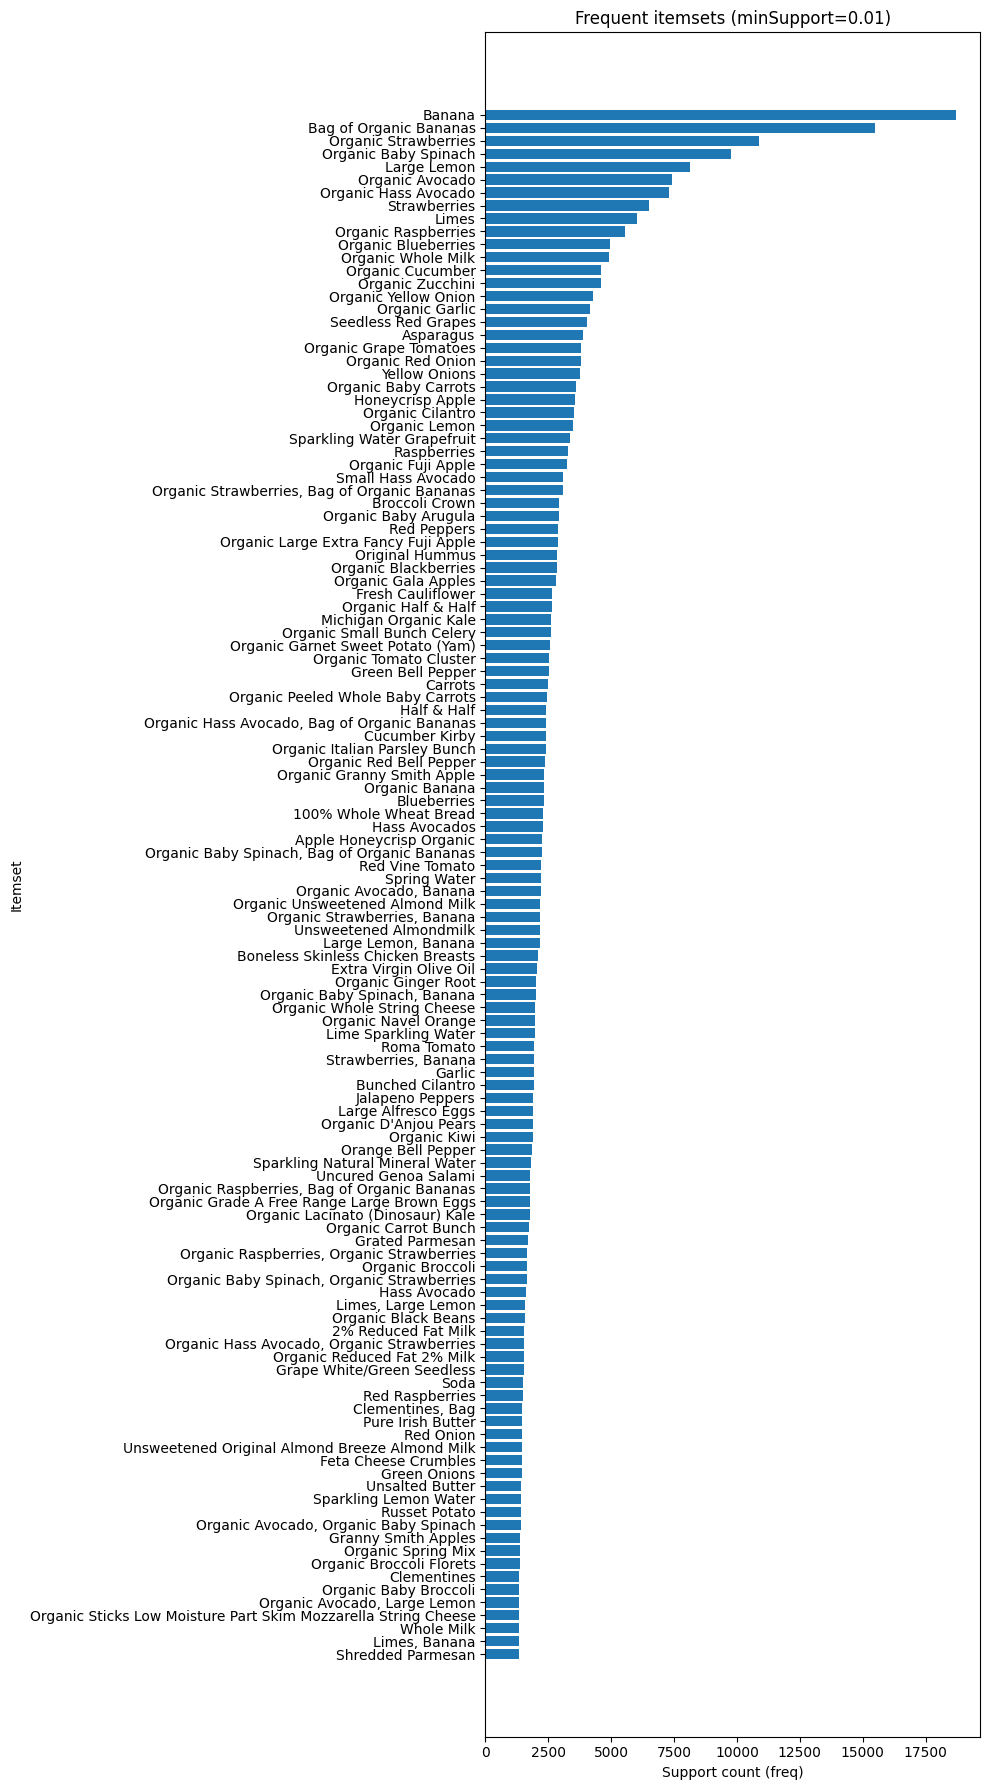

In [15]:
# YOUR CODE HERE
from pyspark.sql.functions import desc, size, concat_ws

all = (fpm_model.freqItemsets
       .withColumn("itemset", concat_ws(", ", "items")).orderBy(desc("freq")).toPandas())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 18))
plt.barh(all["itemset"][::-1], all["freq"][::-1])
plt.xlabel("Support count (freq)")
plt.ylabel("Itemset")
plt.title(f"Frequent itemsets (minSupport=0.01)")
plt.tight_layout()
plt.show()



In [16]:
#count

freqItemsets.count()


120

In [17]:
rules.count()

0

In [18]:
freqItemsets_lower.count()


4444

In [19]:
rules_lower.count()

11

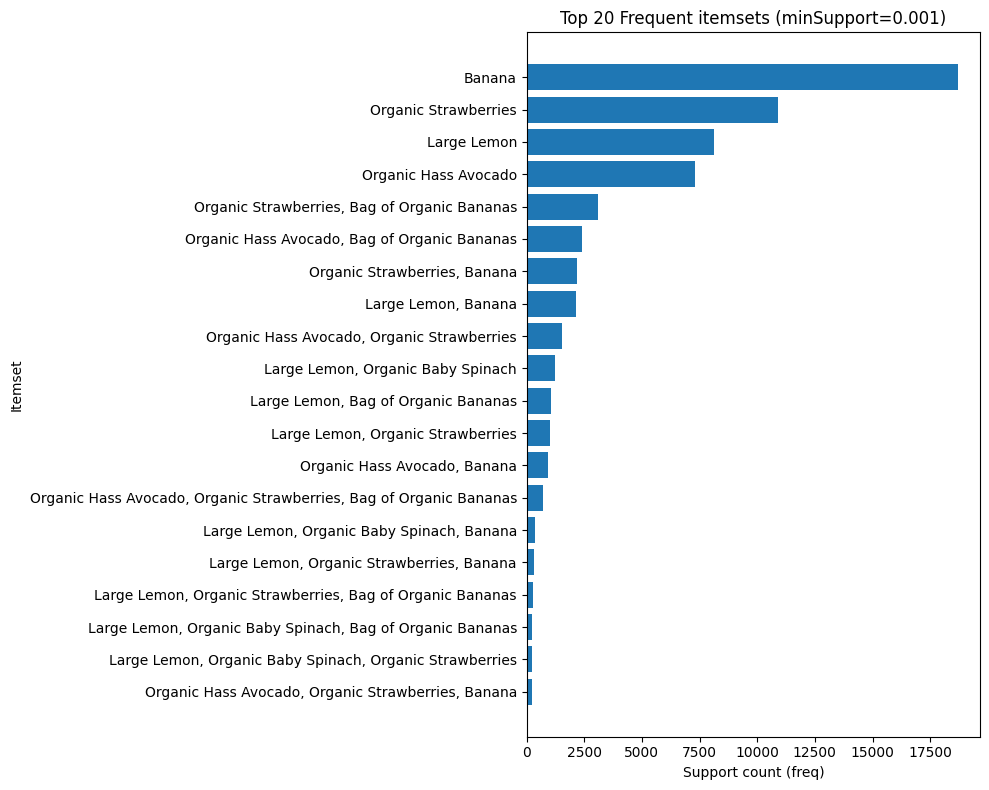

In [20]:
all_lower = (fpm_model_lower_thre.freqItemsets
       .withColumn("itemset", concat_ws(", ", "items")).limit(20).orderBy(desc("freq")).toPandas())


plt.figure(figsize=(10, 8))
plt.barh(all_lower["itemset"][::-1], all_lower["freq"][::-1])
plt.xlabel("Support count (freq)")
plt.ylabel("Itemset")
plt.title(f"Top 20 Frequent itemsets (minSupport=0.001)")
plt.tight_layout()
plt.show()

In [22]:
freqItemsets_lower.where("size(items) = 1 AND items[0] = 'Organic Strawberries'") \
                  .select("freq") \
                  .show()

+-----+
| freq|
+-----+
|10894|
+-----+



In [25]:
rules_lower.where("""
  size(antecedent) = 2 AND
  array_contains(antecedent, 'Organic Broccoli') AND
  array_contains(antecedent, 'Organic Hass Avocado') AND
  size(consequent) = 1 AND
  consequent[0] = 'Bag of Organic Bananas'""").select("*").show(truncate=False)

+----------------------------------------+------------------------+------------------+-----------------+--------------------+
|antecedent                              |consequent              |confidence        |lift             |support             |
+----------------------------------------+------------------------+------------------+-----------------+--------------------+
|[Organic Broccoli, Organic Hass Avocado]|[Bag of Organic Bananas]|0.5048231511254019|4.278897986822536|0.001196564260073623|
+----------------------------------------+------------------------+------------------+-----------------+--------------------+



Once you obtained the desired results, **head over to Gradescope and submit your solution for this Colab**! As a sanity check, for `minSupport=0.01` you should obtain `freq([Limes]) = 6033`